# CSE 291 Homework2 - Random Forests and Boosting  

#### Chao Yu 
#### Wen Liang A53214852

## Random Forests
---
### MNIST
#### Part 1. Read the data and split to training and test sets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, zero_one_loss

import warnings

warnings.filterwarnings('ignore')

mnist_train_path = './MNIST/train.csv'
mnist_train_df = pd.read_csv(mnist_train_path, header=None).T
last_column = mnist_train_df.columns[-1]
mnist_train_df.rename(columns={last_column:'Class'}, inplace=True)

In [2]:
mnist_train_df = mnist_train_df.convert_objects(convert_numeric = True)

In [3]:
X = mnist_train_df.drop(0, axis = 0).drop(0, axis = 1)
y = mnist_train_df.drop(0, axis = 1).as_matrix().T[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.25, random_state=42)

In [4]:
print y_train

[7 8 5 ..., 2 6 0]


In [5]:
X_np = X_train.as_matrix()
print X_np.shape

(31500, 784)


In [6]:
cov_temp = np.diag(np.cov(X_np.T))

In [7]:
# feature selections
idx = []
for i in range(784):
    if cov_temp[i] > 5000:
        idx.append(i)

print idx
X_train2 = X_train.as_matrix()[:, idx]
X_test2 = X_test.as_matrix()[:, idx]

[125, 126, 127, 128, 129, 130, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495,

In [8]:
X_train2.shape

(31500, 293)

methods:
* two_split: split the data into 2 split using a pivot
* entropy: compute the entropy
* entroypy_compute: compute the information gain
* get_split: go through the dataset, randomly choose some features, go through all the splits, find the best one and return
* to_terminal: set the decision on the leaves
* split: split branches from a node
* build_tree: build a tree from root
* predict: get prediction with the tree and observed data
* resample: resample the dataset by the resample ratio
* bagging_predict: get prediction for the forests
* random_forest: build a random forest

In [9]:
from random import randrange
from math import log
import random

def two_split(index, value, dataset):
    left = []
    right = []
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right


def entropy(dataset, classes):
    size = len(dataset)
    if size == 0:
        return 0
    ent = 0.0
    count = [0.0] * len(classes)
    for data in dataset:
        count[classes.index(data[-1])] += 1
    for c in count:
        proportion = c / size
        if proportion != 0:
            ent += -proportion * log(proportion, 2)
    return ent

def entropy_compute(groups, classes):
    dataset = []
    for group in groups:
        dataset += group
    # information for this node
    ent_I = entropy(dataset, classes)
    # information required for subtrees / groups
    ent_remain = 0.0
    for group in groups:
        ent_temp = entropy(group, classes)
        ent_remain += (len(group)*1.0 / len(dataset)) * ent_temp
    return (ent_I - ent_remain)


def get_split(dataset, n_features):
    #X data, y label, n_feartures number of features you want
    features = [];
    classes = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 0, 0, None
    while b_groups is None:
        while len(features) < n_features:
            index = randrange(len(dataset[0]) - 1)
            if index not in features:
                features.append(index)
        for index in features:
            # get value range
            vals = set([row[index] for row in dataset])
            vals = list(vals)
            # cuts
            low, high = min(vals), max(vals)
            diff = (high - low) / 5
            vals = [x * diff + low for x in range(0, 5)]
            for value in vals:
                groups = two_split(index, value, dataset)
                ent = entropy_compute(groups, classes)
                if ent > b_score:
                    b_index, b_value, b_score, b_groups = \
                        index, value, ent, groups
    return {'index':b_index, 'value':b_value, 'groups': b_groups}

def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key = outcomes.count)

# creat child split
def split(node, max_depth, min_size, n_features, depth):
    left, right = node['groups']
    del(node['groups'])
    #print "the depth is", depth
    # check terminate
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left
    classes = list(set(row[-1] for row in (left + right)))
    if len(left) <= min_size or entropy(left, classes) < 0.01:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth+1)
    # process right,
    if len(right) <= min_size or entropy(right, classes) < 0.01:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)

# build a decision tree
def build_tree(train, max_depth, min_size, n_features):
    root = get_split(train, n_features)
    split(root, max_depth, min_size, n_features, 1)
    return root

# prediction
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']
        
# random sample -- bootstrap
def resample(dataset, ratio):
    sample = list()
    num = round(len(dataset) * ratio)
    while len(sample) < num:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

# predict
def bagging_predict(trees, row):
    decisions = [predict(tree, row) for tree in trees]
    return max(set(decisions), key = decisions.count)

# Random Forest
def random_forest(train, test, max_depth, min_size\
                 , sample_ratio, n_trees, n_features):
    trees = []
    for i in range(n_trees):
        samples = resample(train, sample_ratio)
        tree = build_tree(samples, max_depth, min_size, n_features)
        trees.append(tree)
    predictions = [bagging_predict(trees, row) for row in test]
    return predictions


#### Part 4. Find and Visualize the features importance
method:  

* rank_features: compute the information gain for each features and return the list sorted by their importance

In [87]:
def rank_features(dataset):
    info_gain = [];
    classes = list(set(row[-1] for row in dataset))
    features = range(len(dataset[0]))
    for index in features:            
        # get value range
        print "feature: ", index
        vals = set([row[index] for row in dataset])
        vals = list(vals)
        if len(vals) > 25:
            lo = min(vals)
            hi = max(vals)
            diff = (hi - lo) / 25
            vals = [x*diff + lo for x in range(1,25)]
        max_ent = 0;
        for row in dataset:
            for value in vals:
                groups = two_split(index, value, dataset)
                ent = entropy_compute(groups, classes)
                if ent > max_ent:
                    max_ent = ent
        info_gain.append(max_ent)
    feat_gain = [(i, info_gain[i]) for i in range(len(features))]
    feat_gain_sorted = sorted(feat_gain, key= lambda tup: tup[1])
    print "feature - information gain"
    for row in feat_gain_sorted:
        print row
    return feat_gain_sorted

feat_gain_sorted = rank_features(X_test2)
temp = sorted(feat_gain_sorted, key= lambda tup: tup[1],reverse=True)
bb=[]
cc=[]
for i in range(0,53):
    bb.append(temp[i][0])
    cc.append(temp[i][1])
print bb,cc

feature:  0
feature:  1
feature:  2
feature:  3
feature:  4
feature:  5
feature:  6
feature:  7
feature:  8
feature:  9
feature:  10
feature:  11
feature:  12
feature:  13
feature:  14
feature:  15
feature:  16
feature:  17
feature:  18
feature:  19
feature:  20
feature:  21
feature:  22
feature:  23
feature:  24
feature:  25
feature:  26
feature:  27
feature:  28
feature:  29
feature:  30
feature:  31
feature:  32
feature:  33
feature:  34
feature:  35
feature:  36
feature:  37
feature:  38
feature:  39
feature:  40
feature:  41
feature:  42
feature:  43
feature:  44
feature:  45
feature:  46
feature:  47
feature:  48
feature:  49
feature:  50
feature:  51
feature:  52
feature:  53
feature:  54
feature:  55
feature:  56
feature:  57
feature:  58
feature:  59
feature:  60
feature:  61
feature:  62
feature:  63
feature:  64
feature:  65
feature:  66
feature:  67
feature:  68
feature:  69
feature:  70
feature:  71
feature:  72
feature:  73
feature:  74
feature:  75
feature:  76
feature: 

In [94]:
bb2 = [idx[i] for i in bb]
bb2

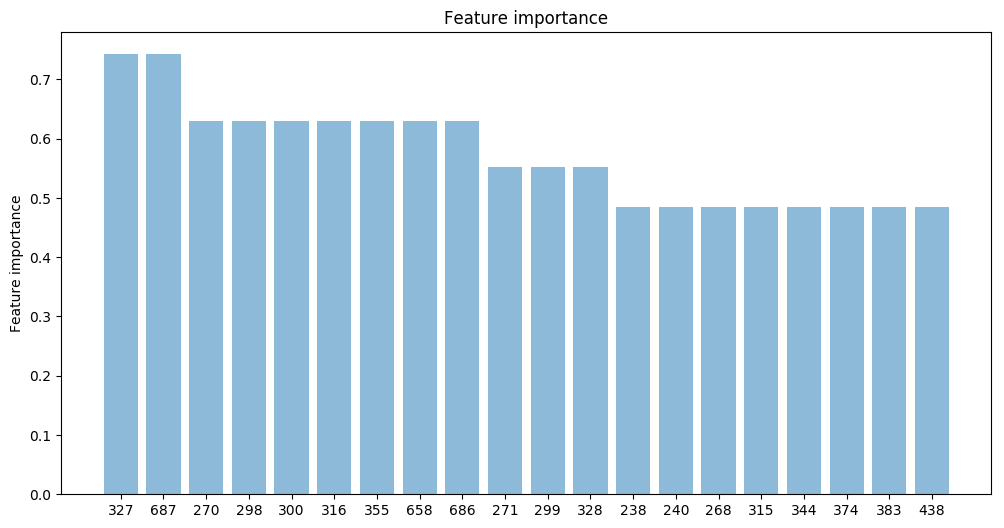

In [96]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
y_pos = np.arange(len(bb2[0:20]))    
plt.figure(figsize=(12,6))
plt.bar(y_pos, cc[0:20], align='center', alpha=0.5)
plt.xticks(y_pos, bb2[0:20])
plt.ylabel('Feature importance')
plt.title('Feature importance')
 
plt.show()

#### Part 2. Train 2 types of RFs
#### Part 3. Investigate the the number of trees
#### Part 5. Show the confusion matrix

In [10]:
train = np.concatenate((X_train2, np.array([y_train]).T), axis = 1)
print train.shape

(31500, 294)


In [11]:
trees = []

In [12]:
# build tree with max_depth 5
n_trees = 100
sample_ratio = 0.4
max_depth = 5
min_size = 30
n_features = 0.4 * len(train[0])

for i in range(n_trees):
    print("tree number " + str(i + 1))
    samples = resample(train, sample_ratio)
    tree = build_tree(samples, max_depth, min_size, n_features)
    trees.append(tree)

tree number 1
tree number 2
tree number 3
tree number 4
tree number 5
tree number 6
tree number 7
tree number 8
tree number 9
tree number 10
tree number 11
tree number 12
tree number 13
tree number 14
tree number 15
tree number 16
tree number 17
tree number 18
tree number 19
tree number 20
tree number 21
tree number 22
tree number 23
tree number 24
tree number 25
tree number 26
tree number 27
tree number 28
tree number 29
tree number 30
tree number 31
tree number 32
tree number 33
tree number 34
tree number 35
tree number 36
tree number 37
tree number 38
tree number 39
tree number 40
tree number 41
tree number 42
tree number 43
tree number 44
tree number 45
tree number 46
tree number 47
tree number 48
tree number 49
tree number 50
tree number 51
tree number 52
tree number 53
tree number 54
tree number 55
tree number 56
tree number 57
tree number 58
tree number 59
tree number 60
tree number 61
tree number 62
tree number 63
tree number 64
tree number 65
tree number 66
tree number 67
tree

In [17]:
# test predictions for trees depth 5
predictions = [bagging_predict(trees, row) for row in X_test2];

from sklearn.metrics import confusion_matrix
import pylab as pl
accuracy = confusion_matrix(y_test,predictions)
print(accuracy)

[[ 959    0    1    5    1   18   12   20    9    0]
 [   0 1081   13   19    1    2    4    6   19    1]
 [  42   37  814   26   21   15   61   31   16    9]
 [  23   27   62  787    7   95   16   28   22   84]
 [  11    5   10    0  661    0   39   14   18  266]
 [  36   13    6  114   23  510   58   25   27   86]
 [  27    9   54    4   28    8  854    6   17    3]
 [   0   22   85    3   13    0    1  937   19   55]
 [   2   81   41   18    8   14   32    4  751   54]
 [  13    8   12   12   35   10   18   60    6  860]]


In [18]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 959    0    1    5    1   18   12   20    9    0]
 [   0 1081   13   19    1    2    4    6   19    1]
 [  42   37  814   26   21   15   61   31   16    9]
 [  23   27   62  787    7   95   16   28   22   84]
 [  11    5   10    0  661    0   39   14   18  266]
 [  36   13    6  114   23  510   58   25   27   86]
 [  27    9   54    4   28    8  854    6   17    3]
 [   0   22   85    3   13    0    1  937   19   55]
 [   2   81   41   18    8   14   32    4  751   54]
 [  13    8   12   12   35   10   18   60    6  860]]


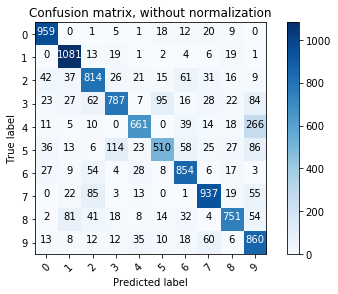

In [19]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7','8','9']
plt.figure()
plot_confusion_matrix(accuracy, classes=labels,
                      title='Confusion matrix, without normalization')
plt.show()

In [25]:
# error rate method
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))
# plot the error rate
def plot_error_rate2(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,100,20))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

In [21]:
# investigate the number of trees
nums = [1, 20, 40, 60, 80, 100]
err_train = []
err_test = []
for n in nums:
    # compute number of errors in each number of trees
    pred_train = [bagging_predict(trees[0:n], row) for row in X_train2]
    pred_test = [bagging_predict(trees[0:n], row) for row in X_test2]
    err_train.append(get_error_rate(pred_train, y_train))
    err_test.append(get_error_rate(pred_test, y_test))

Our decision tree is only 2 splits so the depth = 5 is not a proper parameter. Then we try to show the result with depth = 15

In [62]:
trees_15 = []

In [76]:
# build tree with max_depth 15
n_trees = 60
sample_ratio = 0.4
max_depth = 15
min_size = 30
n_features = 0.4 * len(train[0])

for i in range(n_trees):
    print("tree number " + str(i + 1))
    samples = resample(train, sample_ratio)
    
    tree = build_tree(samples, max_depth, min_size, n_features)
    trees_15.append(tree)

tree number 1
tree number 2
tree number 3
tree number 4
tree number 5
tree number 6
tree number 7
tree number 8
tree number 9
tree number 10
tree number 11
tree number 12
tree number 13
tree number 14
tree number 15
tree number 16
tree number 17
tree number 18
tree number 19
tree number 20
tree number 21
tree number 22
tree number 23
tree number 24
tree number 25


KeyboardInterrupt: 

In [82]:
# test predictions for trees depth 15
predictions_15 = [bagging_predict(trees_15, row) for row in X_test2];

from sklearn.metrics import confusion_matrix
import pylab as pl
accuracy = confusion_matrix(y_test,predictions_15)
print(accuracy)

[[1002    0    4    1    4    6    2    0    4    2]
 [   0 1124    9    1    1    2    6    2    1    0]
 [  12    8  974   10   18    5   18   10   14    3]
 [   4    2   21 1021    3   41    5   17   24   13]
 [   4    2    3    1  955    2    8    2    5   42]
 [   9    2    5   12    4  828   16    2   14    6]
 [  13    2    3    4    8   14  950    1   15    0]
 [   0    8   30    3   13    1    0 1050    5   25]
 [   4   11   17    7    6    6    8    2  934   10]
 [   7    2    5   17   25   12    5   17   11  933]]


Confusion matrix, without normalization
[[1002    0    4    1    4    6    2    0    4    2]
 [   0 1124    9    1    1    2    6    2    1    0]
 [  12    8  974   10   18    5   18   10   14    3]
 [   4    2   21 1021    3   41    5   17   24   13]
 [   4    2    3    1  955    2    8    2    5   42]
 [   9    2    5   12    4  828   16    2   14    6]
 [  13    2    3    4    8   14  950    1   15    0]
 [   0    8   30    3   13    1    0 1050    5   25]
 [   4   11   17    7    6    6    8    2  934   10]
 [   7    2    5   17   25   12    5   17   11  933]]


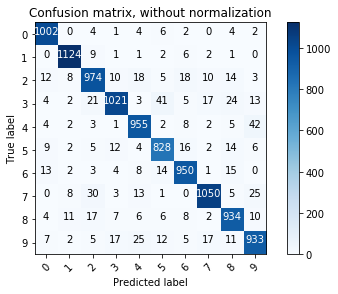

In [84]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7','8','9']
plt.figure()
plot_confusion_matrix(accuracy, classes=labels,
                      title='Confusion matrix, without normalization')
plt.show()

full extent trees

In [27]:
trees_full = []

In [33]:
# build tree with max_depth 100
n_trees = 100
sample_ratio = 0.4
max_depth = 100
min_size = 30
n_features = 0.4 * len(train[0])

for i in range(n_trees):
    print("tree number " + str(i + 1))
    samples = resample(train, sample_ratio)
    
    tree = build_tree(samples, max_depth, min_size, n_features)
    trees_full.append(tree)

tree number 1
tree number 2
tree number 3
tree number 4
tree number 5
tree number 6
tree number 7
tree number 8
tree number 9
tree number 10
tree number 11
tree number 12
tree number 13
tree number 14
tree number 15
tree number 16
tree number 17
tree number 18
tree number 19
tree number 20
tree number 21
tree number 22
tree number 23
tree number 24
tree number 25
tree number 26
tree number 27
tree number 28
tree number 29
tree number 30
tree number 31
tree number 32
tree number 33
tree number 34
tree number 35
tree number 36
tree number 37
tree number 38
tree number 39
tree number 40
tree number 41
tree number 42
tree number 43
tree number 44
tree number 45
tree number 46
tree number 47
tree number 48
tree number 49
tree number 50
tree number 51
tree number 52
tree number 53
tree number 54
tree number 55
tree number 56
tree number 57
tree number 58
tree number 59
tree number 60
tree number 61
tree number 62
tree number 63
tree number 64
tree number 65
tree number 66
tree number 67
tree

In [85]:
# test predictions for trees depth 100
predictions_full = [bagging_predict(trees_full, row) for row in X_test2];

from sklearn.metrics import confusion_matrix
import pylab as pl
accuracy2 = confusion_matrix(y_test,predictions_full)
print(accuracy2)

[[1004    0    3    1    2    5    4    0    5    1]
 [   0 1125    8    0    0    5    4    3    0    1]
 [  14    8  976    8   13    8   17   13   12    3]
 [   3    3   22 1024    2   46    3   16   19   13]
 [   6    1    3    1  960    1    5    3    7   37]
 [  10    2    4   19    2  819   14    2   17    9]
 [  16    2    4    2    8   13  946    0   18    1]
 [   1    8   30    3   13    0    0 1045    7   28]
 [   1   11    7    6    4    7    8    1  946   14]
 [   7    2    6   15   26   11    3   15    8  941]]


Confusion matrix, without normalization
[[1004    0    3    1    2    5    4    0    5    1]
 [   0 1125    8    0    0    5    4    3    0    1]
 [  14    8  976    8   13    8   17   13   12    3]
 [   3    3   22 1024    2   46    3   16   19   13]
 [   6    1    3    1  960    1    5    3    7   37]
 [  10    2    4   19    2  819   14    2   17    9]
 [  16    2    4    2    8   13  946    0   18    1]
 [   1    8   30    3   13    0    0 1045    7   28]
 [   1   11    7    6    4    7    8    1  946   14]
 [   7    2    6   15   26   11    3   15    8  941]]


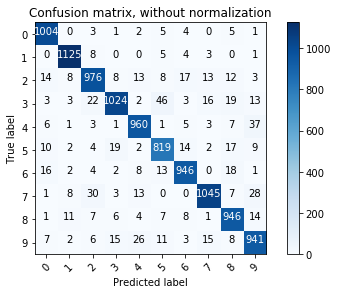

In [86]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7','8','9']
plt.figure()
plot_confusion_matrix(accuracy2, classes=labels,
                      title='Confusion matrix, without normalization')
plt.show()

In [39]:
# investigate the number of trees
nums = [1, 20, 40, 60, 80, 100]
err_train = []
err_test = []
for n in nums:
    # compute number of errors in each number of trees
    pred_train = [bagging_predict(trees_full[0:n], row) for row in X_train2]
    pred_test = [bagging_predict(trees_full[0:n], row) for row in X_test2]
    err_train.append(get_error_rate(pred_train, y_train))
    err_test.append(get_error_rate(pred_test, y_test))

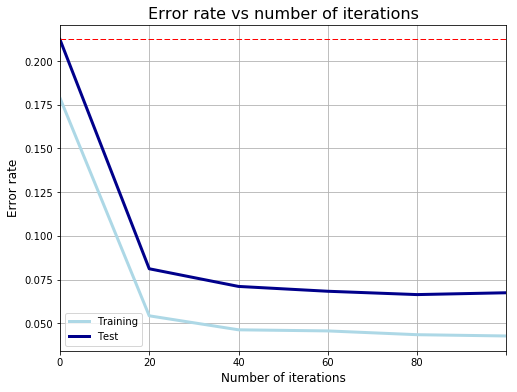

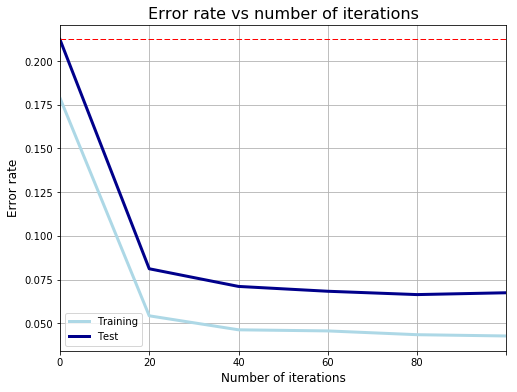

In [41]:
plot_error_rate2(err_train, err_test)
plt.show()

#### Part 6. Plot errors

#### Part 7. Comment on the trends you observed with increasing B for the two types of RFs. 

## Boosting
---
### Covertype
#### Part 1. data preprocessing (already done)
#### Part 2. Implement Adaboost with 2 types of training and test sets

methods:
* adaboost_clf2: multiclass adaboost algorithm, M - number of weak classifiers, Max_depth - max depth of decision tree, Min_split - min split of decision tree

In [59]:
import math
def adaboost_clf2(y_train, X_train, y_test, X_test, M, Max_depth, Min_split):
    n_train, n_test = len(X_train), len(X_test)
    err_test, err_train = [], []
    classes = list(set(y_train))
    n_class = len(classes)
    # initialize weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = np.zeros((n_train, n_class)), np.zeros((n_test, n_class))
    for i in range(M):
        
        clf = DecisionTreeClassifier(max_depth=Max_depth, min_samples_split=Min_split, random_state=42)
        clf.fit(X_train, y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        miss1 = [int(x) for x in (pred_train_i != y_train)]
        err_m = np.dot(w,miss1) / sum(w)
        #print err_m
        alpha_m = np.log((1-err_m) / float(err_m)) + math.log(n_class - 1)
        #print alpha_m
        
        miss2 = [x if x == 1 else -1 for x in miss1]
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        w = w / sum(w)
        #print miss1
        #print miss2
        #print w
        # update
        for i in range(n_train):
            cls = pred_train_i[i]
            idx = classes.index(cls)
            pred_train[i, idx] += alpha_m
        for i in range(n_test):
            cls = pred_test_i[i]
            idx = classes.index(cls)
            pred_test[i, idx] += alpha_m
        
        # get the prediction
        prediction_train = [classes[np.argmax(row)] for row in pred_train]
        #print 'the prediction', prediction_train
        #print 'the y train', y_train
        prediction_test = [classes[np.argmax(row)] for row in pred_test]
        
        # compute current error rate
        err_train.append(get_error_rate(prediction_train, y_train))
        err_test.append(get_error_rate(prediction_test, y_test))
    # confusion matrix
    from sklearn.metrics import confusion_matrix
    accuracy = confusion_matrix(y_test,prediction_test)
    print accuracy
    labels = ['0', '1', '2', '3', '4', '5', '6', '7','8','9']
    plt.figure()
    plot_confusion_matrix(accuracy, classes=labels, title='Confusion matrix, without normalization')
    plt.show()
    return err_train, err_test



#### Part 3. Investigate number of iterations - M
#### Part 4. Confusion matrix
#### Part 6. For each of the two types plot the training error, test error, w.r.t. the number of iterations.

[[753   0  71  14   3 128  26   4  20   6]
 [  0 932   3   4   0 104  29   8  66   0]
 [ 12  68 568  39  23  24 216  36  78   8]
 [ 12  32  26 575   6 194   8  29 250  19]
 [  3   0  41  29 642  29  38  34 130  78]
 [ 17  16   7 122  21 446  52   7 195  15]
 [ 10   4  90  20  32  59 726   2  55  12]
 [ 26  32  22  19  40  22   5 696  44 229]
 [  3  44  21  57   4  42  40  16 749  29]
 [  7   6  46  93 221  45   2  84 186 344]]
Confusion matrix, without normalization
[[753   0  71  14   3 128  26   4  20   6]
 [  0 932   3   4   0 104  29   8  66   0]
 [ 12  68 568  39  23  24 216  36  78   8]
 [ 12  32  26 575   6 194   8  29 250  19]
 [  3   0  41  29 642  29  38  34 130  78]
 [ 17  16   7 122  21 446  52   7 195  15]
 [ 10   4  90  20  32  59 726   2  55  12]
 [ 26  32  22  19  40  22   5 696  44 229]
 [  3  44  21  57   4  42  40  16 749  29]
 [  7   6  46  93 221  45   2  84 186 344]]


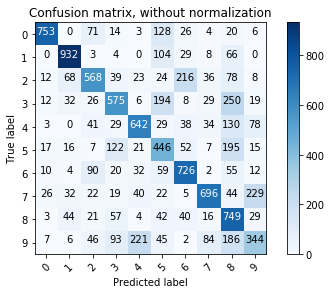

In [56]:
# type one, depth = 1
err_train, err_test=adaboost_clf2(y_train, X_train2, y_test, X_test2, 100, 1, 2)

In [71]:
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,200,20))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

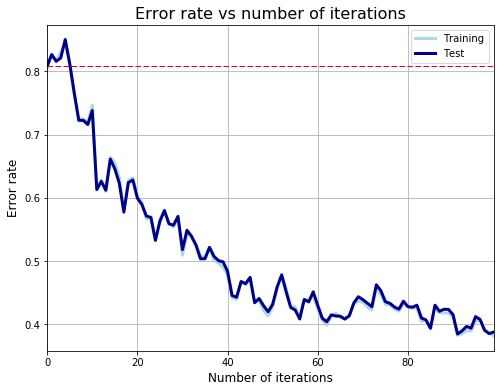

In [72]:
plot_error_rate(err_train, err_test)
plt.show()

[[1001    0    2    1    0    9    5    2    3    2]
 [   0 1134    3    2    1    1    1    2    1    1]
 [   3    5 1012   10    9    3    4   10   11    5]
 [   0    3    6 1066    2   19    2    9   26   18]
 [   2    0    4    0  978    0    4    2    1   33]
 [   2    0    1   26    1  847    7    1    5    8]
 [   6    1    1    1   10   13  971    0    7    0]
 [   0    6   14    1    7    1    0 1063    3   40]
 [   1    4    8   15    6    8    0    4  947   12]
 [   5    1    3   14   10    6    2    8    4  981]]
Confusion matrix, without normalization
[[1001    0    2    1    0    9    5    2    3    2]
 [   0 1134    3    2    1    1    1    2    1    1]
 [   3    5 1012   10    9    3    4   10   11    5]
 [   0    3    6 1066    2   19    2    9   26   18]
 [   2    0    4    0  978    0    4    2    1   33]
 [   2    0    1   26    1  847    7    1    5    8]
 [   6    1    1    1   10   13  971    0    7    0]
 [   0    6   14    1    7    1    0 1063    3   40]
 [   

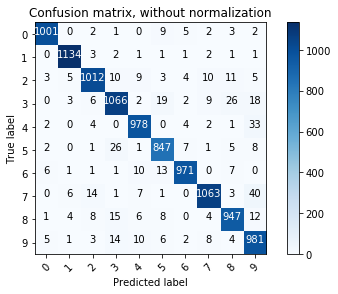

In [74]:
# type two, depth = 10
err_train2, err_test2=adaboost_clf2(y_train, X_train2, y_test, X_test2, 150, 10, 2)


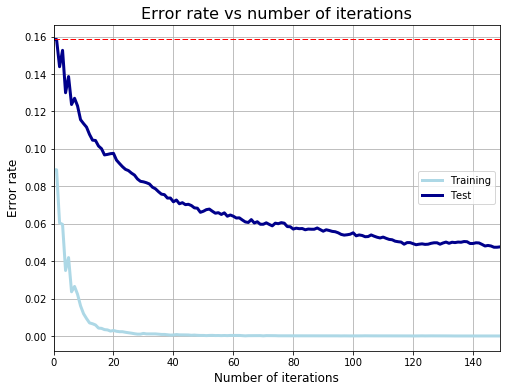

In [75]:
plot_error_rate(err_train2, err_test2)
plt.show()

#### Part 5.Analyze and explain the trends you noted that may justify your results and parameter choices

#### Part 7. Comment on the trends you observed with increasing iterations for the two types of learners